This will be a short notebook, reserved only for the Logistic Regression Model. We will use the cleaned & lemmatized dataset that we have exported as a .csv file during the preprocessing part.

In [192]:
import warnings
warnings.simplefilter("ignore", UserWarning)

warnings.simplefilter("ignore", FutureWarning)


In [2]:
import pandas as pd
import numpy as np
import json
import math
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, roc_auc_score, f1_score, confusion_matrix

import scipy
from scipy.sparse import hstack

# This module will be for saving the trained model for later use
import joblib

import spacy
import re

In [166]:
import spacy
import re

nlp = spacy.load('en_core_web_sm')


# Should be (almost) the same as Canberk's, but slighlty faster, as not compiling the regex each time
regex1 = re.compile(r'(http\S+)|(#(\w+))|(@(\w+))|[^\w\s]|(\w*\d\w*)')
regex2 = re.compile(r'(\s+)|(\n+)')

def lemmatize(article):
    article = re.sub(regex1, '', article)
    article = re.sub(regex2,' ', article).strip().lower()
    
    doc = nlp(article)
    lemmatized_article = " ".join([token.lemma_ for token in doc if (token.is_stop==False)]) 
    
    return lemmatized_article

In [167]:
am = pd.read_csv('../adverse_media_training.csv.zip')
nam = pd.read_csv('../non_adverse_media_training.csv.zip')

am_confirmed = am.loc[(am.label == 'am') | (am.label == 'am ')]
am_confirmed = pd.concat([am_confirmed, nam.loc[nam.label == 'am']])

nam_confirmed = nam.loc[(nam.label == 'nam') | (nam.label == 'random')]
nam_confirmed = pd.concat([nam_confirmed, am.loc[(am.label == 'nam') | (am.label == 'random')]])

am_confirmed['is_adverse_media'] = 1
nam_confirmed['is_adverse_media'] = 0

# Creating the train dataset
data = pd.concat([am_confirmed, nam_confirmed])
print(data.shape)
print()
print(data['is_adverse_media'].value_counts())


(729, 12)

1    411
0    318
Name: is_adverse_media, dtype: int64


In [168]:
data["article"] = data["title"] + " " + data["article"]
data["lemmatized"] = data["article"].apply(lemmatize)

data = data.sample(frac = 1, random_state=42)
data = data.reset_index()
data = data.drop(['index'], axis=1)

In [169]:

data[data.is_adverse_media == 0].shape, data[data.is_adverse_media == 1].shape

((318, 13), (411, 13))

In [170]:
orig_df = data.copy()

orig_df['proba0'] = 0.0
orig_df['proba1'] = 0.0

In [171]:
import pandas as pd
from sklearn.model_selection import KFold 
 
#Cross validation
 
k = 20
kf = KFold(n_splits=k, random_state=42, shuffle=True)
 
for train_index , test_index in kf.split(data):
    x_train , x_val = data.iloc[train_index,:].lemmatized, data.iloc[test_index,:].lemmatized
    y_train , y_val = data['is_adverse_media'][train_index], data['is_adverse_media'][test_index]
    print(f'validation set {len(y_val)}')
    print(f'has {sum(y_val)} am-s')
    ngram_vectorizer = TfidfVectorizer(max_features=40000,
                             min_df=5, 
                             max_df=0.5, 
                             analyzer='word', 
                             stop_words='english', 
                             ngram_range=(1, 3))
    ngram_vectorizer.fit(x_train)
    
    tfidf_train = ngram_vectorizer.transform(x_train)
    tfidf_validation = ngram_vectorizer.transform(x_val)
    
    lr = LogisticRegression(solver='sag', random_state=42)
    lr.fit(tfidf_train, y_train)
    
    probabilities_with_lemmatized_articles = np.append(lr.predict_proba(tfidf_validation), x_val.to_numpy().reshape((len(x_val), 1)), axis=1)

    proba_df = pd.DataFrame(probabilities_with_lemmatized_articles, columns= ['proba0', 'proba1', 'lemmatized'])

    for i in range(len(proba_df)):
        current_proba = proba_df.iloc[i,:]
        orig_df.loc[orig_df.lemmatized == current_proba.lemmatized, 'proba0'] = current_proba['proba0']
        orig_df.loc[orig_df.lemmatized == current_proba.lemmatized, 'proba1'] = current_proba['proba1']


validation set 37
has 20 am-s
validation set 37
has 19 am-s
validation set 37
has 23 am-s
validation set 37
has 22 am-s
validation set 37
has 17 am-s
validation set 37
has 23 am-s
validation set 37
has 21 am-s
validation set 37
has 24 am-s
validation set 37
has 20 am-s
validation set 36
has 22 am-s
validation set 36
has 21 am-s
validation set 36
has 25 am-s
validation set 36
has 25 am-s
validation set 36
has 14 am-s
validation set 36
has 16 am-s
validation set 36
has 17 am-s
validation set 36
has 18 am-s
validation set 36
has 24 am-s
validation set 36
has 21 am-s
validation set 36
has 19 am-s


In [172]:
orig_df.to_csv('../original_training_data_with_probabilities_from_logit_model.csv', index=False)

In [173]:
orig_df[orig_df['proba0'] == 0.0]

,source,entity_name,entity_type,url,article,full_response,label,explanation,assessor,comment,title,is_adverse_media,lemmatized,proba0,proba1


In [157]:
!zip ../original_training_data_with_probabilities_from_logit_model.csv.zip ../original_training_data_with_probabilities_from_logit_model.csv

  adding: ../original_training_data_with_probabilities_from_logit_model.csv (deflated 82%)


In [180]:
dff = pd.read_csv('../original_training_data_with_probabilities_from_logit_model.csv.zip')


dff.describe()

,is_adverse_media,proba0,proba1
count,729.000000,729.000000,729.000000
mean,0.563786,0.434263,0.565737
std,0.496255,0.225806,0.225806
min,0.000000,0.065126,0.070439
25%,0.000000,0.231254,0.361939
50%,1.000000,0.392127,0.607873
75%,1.000000,0.638061,0.768746
max,1.000000,0.929561,0.934874


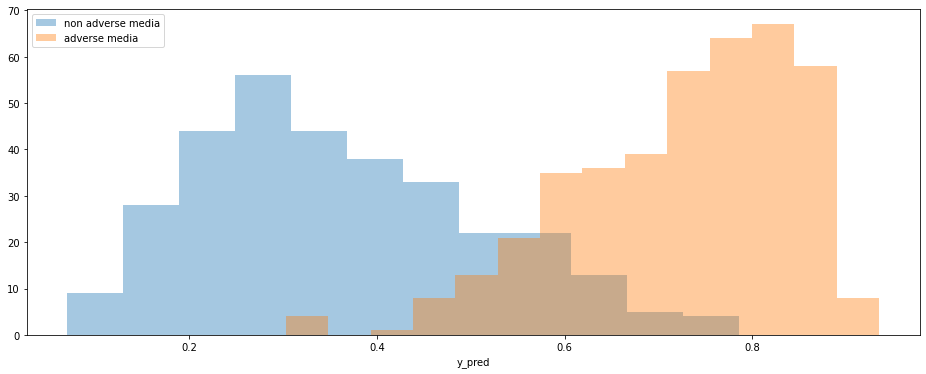

In [194]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
df_pred = pd.DataFrame(data={'y_actual': dff['is_adverse_media'], 'y_pred': dff['proba1']})
msk = df_pred['y_actual'] == 1
sns.distplot(df_pred.loc[~msk, 'y_pred'], label='non adverse media', kde=False)
sns.distplot(df_pred.loc[msk, 'y_pred'], label='adverse media', kde=False)
plt.legend()